# ENGI E1006 - Intro to Computing for Engineers & Applied Scientists
## Group Project 2
Due: 11:59pm on Monday Nov 24

Total Points: 100

In [26]:
import random
import math
from matplotlib import pyplot as plt
import numpy as np
import pygame    


pygame 2.6.1 (SDL 2.28.4, Python 3.12.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


The following function is an example illustrating how to display an image using matplotlib.

In [27]:
def image_example():
    '''should produce red,purple,green squares
    on the diagonal, over a black background'''
    # RGB indexes
    red,green,blue = range(3)
    # img array 
    # all zeros = black pixels
    # shape: (150 rows, 150 cols, 3 colors)
    img = np.zeros((150,150,3))
    for x in range(50):
        for y in range(50):
            # red pixels
            img[x,y,red] = 1.0
            # purple pixels
            # set 3 color components 
            img[x+50, y+50,:] = (.5,.0,.5)
            # green pixels
            img[x+100,y+100,green] = 1.0
    plt.imshow(img)

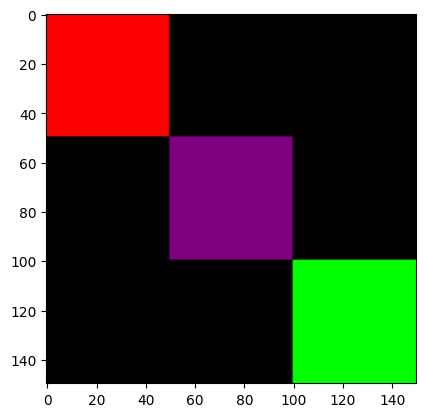

In [28]:
%matplotlib inline  
image_example()

The following functions are used to calculate the probability of a cell dying at a certain time step after being infected.

In [29]:


def normpdf(x, mean, sd):
    """
    Return the value of the normal distribution 
    with the specified mean and standard deviation (sd) at
    position x.
    You do not have to understand how this function works exactly. 
    """
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

def pdeath(x, mean, sd):
    start = x-0.5
    end = x+0.5
    step =0.01    
    integral = 0.0
    while start<=end:
        integral += step * (normpdf(start,mean,sd) + normpdf(start+step,mean,sd)) / 2
        start += step            
    return integral    
    


Some constants we will use later in the simulation: 

In [30]:
recovery_time = 4  # recovery time in time-steps
virality = 0.2       # probability that a neighbor cell is infected in each time step

# Parameters for mortality (Step 4)
death_mean = 3       # average number of steps until death
death_sd = 1         # standard deviation of steps until death


This is where your code starts.

In [31]:
class Cell(object):

    def __init__(self, x, y):
        self.x = x
        self.y = y
        # "S" (susceptible), "R" (resistant / dead), "I" (infected)
        self.state = "S"
        # how many time steps this cell has been infected
        self.time = 0

    def infect(self):
        """
        Infect this cell and reset the infection timer.
        """
        self.state = "I"
        self.time = 0

    def process(self, adjacent_cells):
        """
        Process this cell for one time step.

        Only cells in state "I" (infected) change.
        Processing order for an infected cell:
        1. Check if it recovers (state I -> S).
        2. If it does not recover, check if it dies (state I -> R).
        3. If it is still infected and has been infected for at least
           one time step, attempt to infect susceptible neighbors.
        4. Finally, advance the internal infection timer.
        """
        from random import random
        global virality, recovery_time, death_mean, death_sd

        # Only infected cells change over time.
        if self.state != "I":
            return

        # 1) Recovery: if we have been infected long enough, recover.
        if self.time >= recovery_time:
            self.state = "S"
            self.time = 0
            return

        # 2) Mortality: decide if the cell dies at this time step.
        #    Use the normal-distribution-based probability pdeath.
        if random() <= pdeath(self.time, death_mean, death_sd):
            self.state = "R"
            # Once dead, we do not infect others or advance the timer further.
            return

        # 3) Infection of neighbors.
        # Newly infected cells (time == 0) cannot yet infect others.
        if self.time < 1:
            # Just advance the timer to indicate one time step has passed.
            self.time += 1
            return

        # If we reach this point, the cell is infected, has not recovered
        # or died this step, and has been infected for at least 1 step.
        for neighbor in adjacent_cells:
            if neighbor.state == "S":
                if random() <= virality:
                    neighbor.infect()

        # 4) Advance infection timer after attempting infections.
        self.time += 1


In [32]:
class Map(object):

    def __init__(self):
        self.height = 150
        self.width = 150
        self.cells = {}

    def add_cell(self, cell):
        """
        Insert a Cell object into the map at its (x, y) coordinates.
        """
        self.cells[(cell.x, cell.y)] = cell

    def display(self):
        """
        Display the current state of the map as an RGB image using matplotlib.
        Susceptible (S): green
        Infected   (I): red
        Resistant  (R): gray
        Empty      (no cell): black
        """
        red, green, blue = range(3)
        img = np.zeros((self.height, self.width, 3))

        for (x, y), cell in self.cells.items():
            if cell.state == "S":
                img[x, y, green] = 1.0
            elif cell.state == "I":
                img[x, y, red] = 1.0
            elif cell.state == "R":
                img[x, y, :] = 0.5  # gray

        plt.imshow(img)
        plt.axis("off")

    def adjacent_cells(self, x, y):
        """
        Return a list of Cell objects adjacent to (x, y).
        Adjacent = N, E, S, W (no diagonals).
        """
        neighbors = []
        directions = [
            (0, -1),   # north
            (1, 0),    # east
            (0, 1),    # south
            (-1, 0)    # west
        ]

        for dx, dy in directions:
            nx = x + dx
            ny = y + dy
            # boundary check
            if 0 <= nx < self.width and 0 <= ny < self.height:
                if (nx, ny) in self.cells:
                    neighbors.append(self.cells[(nx, ny)])

        return neighbors

    def time_step(self, show=True):  # updated version with show argument
        """
        Process the map for one time step.
        If show is True, draw using matplotlib.
        """
    # copy list so iteration is safe
        all_cells = list(self.cells.values())

        for cell in all_cells:
            adj = self.adjacent_cells(cell.x, cell.y)
            cell.process(adj)

        if show:
            self.display()


In [33]:
def read_map(filename):
    """
    Read map data from a CSV file of "x,y" coordinate pairs and
    return a Map instance filled with Cell objects at those locations.
    """
    m = Map()

    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            x_str, y_str = line.split(",")
            x = int(x_str)
            y = int(y_str)

            cell = Cell(x, y)
            m.add_cell(cell)

    return m


In [34]:
m = read_map("nyc_map.csv")
m.cells[(39,82)].infect()

#original test case

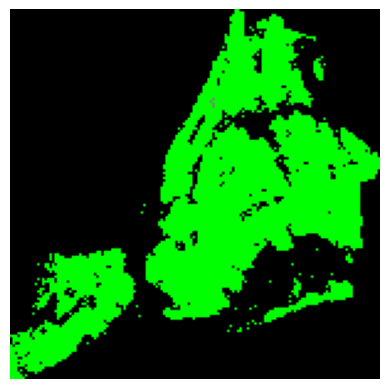

In [35]:
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.display()

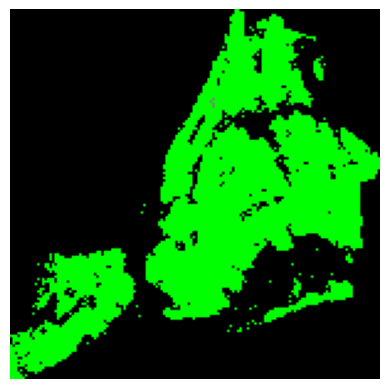

In [36]:
#new test case w/ virality 0.8

recovery_time = 4  # recovery time in time-steps
virality = 0.8      # probability that a neighbor cell is infected in each time step

# Parameters for mortality (Step 4)
death_mean = 3       # average number of steps until death
death_sd = 1         # standard deviation of steps until death

k = read_map("nyc_map.csv")
k.cells[(39,82)].infect()

m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.time_step()
m.display()


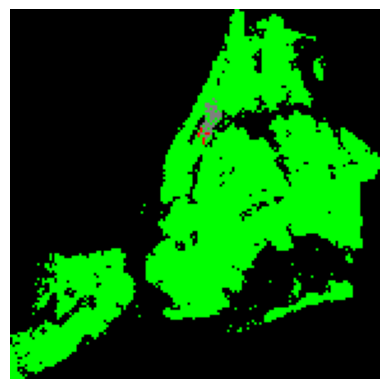

In [40]:
# =========================================
# Step 5: example experiment with parameters
# =========================================

# adjust parameters and see how the disease behaves

virality = 0.35        # prob that an infected cell infects a susceptible neighbor
recovery_time = 4      # number of steps until an infected cell recovers
mean_death = 3.0       # mean of normal distribution for time of death
stdev_death = 1.0      # standard deviation for time of death

# if your pdeath(x, mean, stdev) already uses global mean and stdev,
# set them here too
death_mean = mean_death
death_stdev = stdev_death

# build a fresh map
m = read_map("nyc_map.csv")

# infect one starting cell (you can change the coordinate)
start_x, start_y = 39, 82
m.cells[(start_x, start_y)].infect()

# run the simulation for N steps and display each one
num_steps = 40
for step in range(num_steps):
    m.time_step()


In [38]:
import pygame

def draw_map_on_pygame(surface, m, cell_size):
    """
    Draw the current state of map m onto the pygame surface.
    cell_size is the number of pixels per cell.
    """
    for (x, y), cell in m.cells.items():
        # choose color based on cell state
        if cell.state == "S":
            color = (0, 255, 0)        # green
        elif cell.state == "I":
            color = (255, 0, 0)        # red
        elif cell.state == "R":
            color = (128, 128, 128)    # gray
        else:
            color = (0, 0, 0)          # background

        # note: x is row, y is column
        rect = pygame.Rect(y * cell_size, x * cell_size,
                           cell_size, cell_size)
        pygame.draw.rect(surface, color, rect)


def run_pygame_simulation(m, num_steps=200, cell_size=4, fps=10):
    """
    Run an animated simulation of the disease spread using pygame.
    Press the window close button to exit early.
    """
    pygame.init()
    width = m.width * cell_size
    height = m.height * cell_size
    screen = pygame.display.set_mode((width, height))
    pygame.display.set_caption("Infectious disease simulation")

    clock = pygame.time.Clock()
    running = True
    step = 0

    while running and step < num_steps:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        # advance the model by one time step without matplotlib
        m.time_step(show=False)

        # draw the new state
        screen.fill((0, 0, 0))
        draw_map_on_pygame(screen, m, cell_size)
        pygame.display.flip()

        clock.tick(fps)   # limit frames per second
        step += 1

    pygame.quit()


In [39]:
m = read_map("nyc_map.csv")
m.cells[(39, 82)].infect()

run_pygame_simulation(
    m,
    num_steps=300,
    cell_size=4,
    fps=8
)
